In [ ]:
# #Clone các repo chính của thuật toán, nếu đã có workspace, comment cell này lại.
# !git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
# %cd Hierarchical-Localization
# !pip install --progress-bar off --quiet -e .
# !pip install --progress-bar off --quiet --upgrade plotly

/kaggle/working/Hierarchical-Localization/Hierarchical-Localization


In [2]:
%load_ext autoreload
%autoreload 2
#Thư viện cho việc xây dựng mô hình 3D
from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
    pairs_from_exhaustive,
    localize_sfm,
)

#Thư viện cho việc xem các mô hình 3D đã xây dựng
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# #Thư viện mount sang các thư mục trên google drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# Tạo đường dẫn và config
images = Path("datasets/hcmus_indoor/")

outputs = Path("outputs/hcmus_indoor/")
sfm_pairs = outputs / "pairs-netvlad.txt"
reference_sfm = outputs / "sfm_superpoint+superglue"
loc_pairs = outputs / 'pairs-loc.txt'
feature_path = outputs / 'feats-superpoint-n4096-r1024.h5'
match_path = outputs / 'feats-superpoint-n4096-r1024_matches-superglue_pairs-netvlad.h5'


retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_inloc"]
matcher_conf = match_features.confs["superglue"]

In [ ]:
# retrieval_path = extract_features.main(retrieval_conf, images, outputs)
# pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=10)
# print(retrieval_path)

[2024/11/14 18:25:20 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/11/14 18:25:20 hloc INFO] Found 302 images in root /kaggle/input/hcmus-indoor/hcmus_indoor.
100%|██████████| 529M/529M [00:24<00:00, 22.3MB/s] 
100%|██████████| 302/302 [00:30<00:00,  9.98it/s]
[2024/11/14 18:26:25 hloc INFO] Finished exporting features.
[2024/11/14 18:26:25 hloc INFO] Extracting image pairs from a retrieval database.
[2024/11/14 18:26:26 hloc INFO] Found 3020 pairs.


outputs/hcmus-indoor/global-feats-netvlad.h5


In [ ]:
# feature_path = extract_features.main(feature_conf, images, outputs)
# match_path = match_features.main(
#     matcher_conf, sfm_pairs, feature_conf["output"], outputs
# )

[2024/11/14 18:27:07 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[2024/11/14 18:27:07 hloc INFO] Found 302 images in root /kaggle/input/hcmus-indoor/hcmus_indoor.
[2024/11/14 18:27:07 hloc INFO] Skipping the extraction.
[2024/11/14 18:27:07 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 1496/1496 [01:58<00:00, 12.61it/s]
[2024/11/14 18:29:06 hloc INFO] Finished exporting matches.


In [ ]:
# model = reconstruction.main(reference_sfm, images, sfm_pairs, feature_path, match_path)

In [5]:
import pycolmap
model = pycolmap.Reconstruction(reference_sfm)

In [6]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

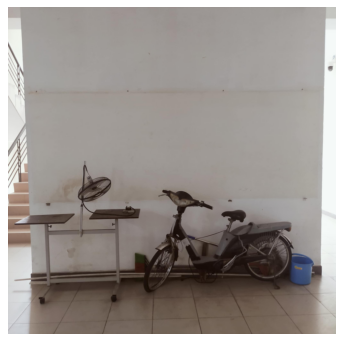

In [7]:
query="query/10.jpg"
plot_images([read_image(images / query)], dpi=75)

In [8]:
retrieval_path=Path("outputs/hcmus_indoor/global-feats-netvlad.h5")

In [19]:
feature_query=Path("outputs/hcmus_indoor/feats-superpoint-n4096-r1024.h5")
feature_path=Path("outputs/hcmus_indoor/feats-superpoint-n4096-r1600.h5")
references_registered = [model.images[i].name for i in model.reg_image_ids()]

In [22]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=feature_query, overwrite=True)

[2024/11/15 11:51:40 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}


Loaded SuperPoint model


100%|██████████| 1/1 [00:16<00:00, 16.57s/it]
[2024/11/15 11:51:57 hloc INFO] Finished exporting features.


PosixPath('outputs/hcmus_indoor/feats-superpoint-n4096-r1024.h5')

In [ ]:
pairs_from_retrieval.main(
    retrieval_path, loc_pairs, num_matched=10, db_prefix="db", query_prefix=query
)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=feature_path, matches=match_path, overwrite=True);

[2024/11/15 11:52:33 hloc INFO] Found 149 pairs.
[2024/11/15 11:52:33 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


/Users/vobahoangnhat/University/Khoá Luận/hloc_run/Hierarchical-Localization/hloc/extractors/../../third_party/SuperGluePretrainedNetwork/models/superglue.py:226: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues 

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/Users/vobahoangnhat/University/Khoá Luận/hloc_run/Hierarchical-Localization/hloc/match_features.py", line 119, in __getitem__
    grp = fd[name0]
          ~~^^^^^^^
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/h5py/_hl/group.py", line 357, in __getitem__
    oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5o.pyx", line 257, in h5py.h5o.open
KeyError: 'Unable to open object (component not found)'


In [134]:
# print(feature_path)

outputs/hcmus-indoor/feats-superpoint-n4096-r1600.h5


In [132]:
# import pycolmap
# from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

# camera = pycolmap.infer_camera_from_image(images / query)
# ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
# conf = {
#     'estimation': {'ransac': {'max_error': 12}},
#     'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
# }
# localizer = QueryLocalizer(model, conf)
# ret, log = pose_from_cluster(localizer, query, camera, ref_ids, feature_path, match_path)

# print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
# visualization.visualize_loc_from_log(images, query, log, model)

ValueError: Could not find pair ('query/10.jpg', 'db/I_8/004/IMG_3240.JPG')... Maybe you matched with a different list of pairs? 

In [126]:
# fig = viz_3d.init_figure()
# pose = pycolmap.Image(cam_from_world=ret['cam_from_world'])
# viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# # visualize 2D-3D correspodences
# import numpy as np
# inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
# viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
# fig.show()